# 프로젝트 : 다양한 OCR모델 비교하기

### 라이브러리 import

In [1]:
import os
import keras_ocr
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
from pytesseract import Output

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


### 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것\
이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요

In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://images.unsplash.com/photo-1568132114436-d2bff6e9ff8c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2942&q=80',
  'https://images.unsplash.com/photo-1503542724004-53e16040c0c9?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1287&q=80',
  'https://images.unsplash.com/photo-1528716321680-815a8cdb8cbe?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2565&q=80',
  'https://images.unsplash.com/photo-1498435999018-6803de1f1c1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2946&q=80',
  'https://images.unsplash.com/photo-1541745183274-cb9189bfe734?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

### keras-ocr

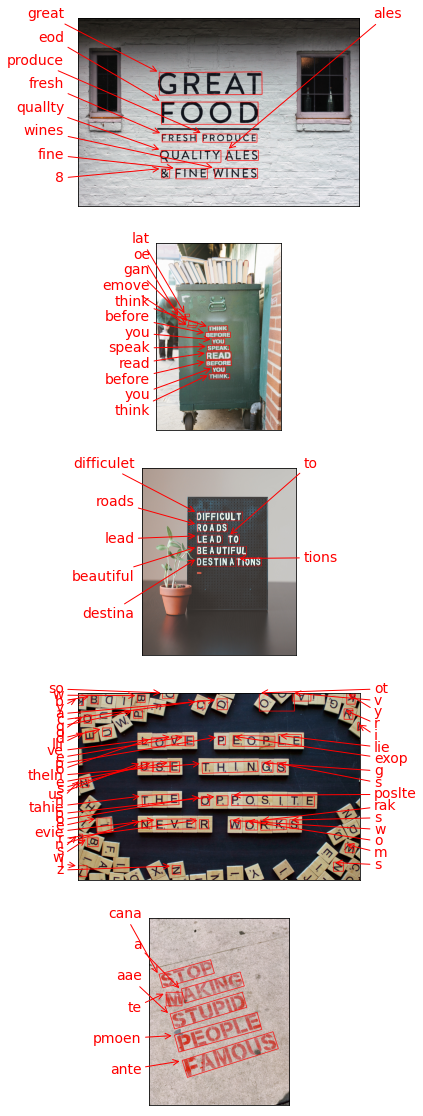

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. \
우리는 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.

In [25]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

print("=3")

=3


위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, \
검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.\

기본적으로 pytesseract.image_to_data() 를 사용합니다. \
파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 주게 됩니다. \
이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. \
바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 \
cropped_image_path_list에 담아 리턴하였습니다.

In [23]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python_project'
img_file_path = work_dir + '/pompom.jpg'
# img_file_path1 = work_dir + '/1.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
# img_file_path2 = work_dir + '/2.png'
# img_file_path3 = work_dir + '/3.png'
# img_file_path4 = work_dir + '/4.png'
# img_file_path5 = work_dir + '/5.png'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
# cropped_image_path_list1 = crop_word_regions(img_file_path1, work_dir)
# cropped_image_path_list2 = crop_word_regions(img_file_path2, work_dir)
# cropped_image_path_list3 = crop_word_regions(img_file_path3, work_dir)
# cropped_image_path_list4 = crop_word_regions(img_file_path4, work_dir)
# cropped_image_path_list5 = crop_word_regions(img_file_path5, work_dir)

E0313 13:46:40.188424406      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python_project/0000.png
/aiffel/aiffel/ocr_python_project/0001.png
/aiffel/aiffel/ocr_python_project/0002.png
/aiffel/aiffel/ocr_python_project/0003.png
/aiffel/aiffel/ocr_python_project/0004.png
/aiffel/aiffel/ocr_python_project/0005.png
/aiffel/aiffel/ocr_python_project/0006.png
/aiffel/aiffel/ocr_python_project/0007.png
/aiffel/aiffel/ocr_python_project/0008.png
/aiffel/aiffel/ocr_python_project/0009.png
/aiffel/aiffel/ocr_python_project/0010.png
/aiffel/aiffel/ocr_python_project/0011.png
/aiffel/aiffel/ocr_python_project/0012.png
/aiffel/aiffel/ocr_python_project/0013.png
/aiffel/aiffel/ocr_python_project/0014.png
/aiffel/aiffel/ocr_python_project/0015.png
/aiffel/aiffel/ocr_python_project/0016.png
/aiffel/aiffel/ocr_python_project/0017.png
/aiffel/aiffel/ocr_python_project/0018.png
/aiffel/aiffel/ocr_python_project/0019.png
/aiffel/aiffel/ocr_python_project/0020.png
/aiffel/aiffel/ocr_python_project/0021.png
/aiffel/aiffel/ocr_python_project/0022.png
/aiffel/aif

In [28]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/receipt2.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

E0313 13:54:16.248466238      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
/aiffel/aiffel/ocr_python/0024.png
/aiffel/aiffel/ocr_python/0025.png
/aiffel/aiffel/ocr_python/0026.png
/aiffel/aiffel/ocr_python/0027.png
/aiffel/aiffel/ocr_p

4) 테서랙트로 잘린 이미지에서 단어 인식하기

이제 문자 인식을 해 볼 차례입니다. \
검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 됩니다.

In [29]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

E0313 13:54:37.753755200      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:37.942229214      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


YORA

BOOT HAM

| OCAL



E0313 13:54:38.151303926      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:38.324026982      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Sainsbury s

supermarkets



E0313 13:54:38.553216738      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:38.749796073      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


itd

44



E0313 13:54:38.916102851      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:39.086681214      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


HO ;porn

London



E0313 13:54:39.290691971      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:39.487264982      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


FCN

OHI



E0313 13:54:39.677851777      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:39.850753802      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


AI

Salnsburys



E0313 13:54:40.035989642      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:40.221739028      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


co.uk

Vat



E0313 13:54:40.402042036      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:40.575876074      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Number

g



E0313 13:54:40.752805327      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:40.905849486      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


bit)

a54a5



E0313 13:54:41.078971543      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:41.273788498      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


3h

MAN ANA



E0313 13:54:41.448667361      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:41.643896316      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


SINGLE

1



E0313 13:54:41.839679106      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:41.998990030      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


BALANCE

vis



E0313 13:54:42.197559131      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:42.373724412      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


CASH



E0313 13:54:42.553639474      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


CHANGE

5



E0313 13:54:42.762768280      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:42.942467016      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:43.100011455      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Hi

A) + 23



E0313 13:54:43.324997107      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ITHAUGZULS

0272



E0313 13:54:43.551128425      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:43.709726157      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


a

S04930



E0313 13:54:43.922474703      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:44.118919091      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ROBZ

Rased



E0313 13:54:44.291387251      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:44.464709363      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ue

price



E0313 13:54:44.638699909      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:44.810577230      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


perception

data,



E0313 13:54:44.996860884      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:45.160223445      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


YOU

Cal}



E0313 13:54:45.333907712      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:45.518516868      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


li Ve

we | |



E0313 13:54:45.687482067      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:45.867121677      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Tor

less



E0313 13:54:46.039566448      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:46.202238527      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Than

YOU



E0313 13:54:46.385917981      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:46.549458646      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


thought

at



E0313 13:54:46.737066476      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:46.890927936      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Sainsbury s.

For



E0313 13:54:47.084398683      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:47.246515035      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ne

information



E0313 13:54:47.442699510      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:47.632203436      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


WoO

To



E0313 13:54:47.802286091      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0313 13:54:47.958935662      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


sainsburys



E0313 13:54:48.134001033      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


co.uk/livewel | foriess


Done


E0313 13:54:48.543987987      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


### Google OCR API

In [18]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [21]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/shaped-clarity-380503-a8c994d3e213.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/pompom.jpg'# [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

E0313 13:43:17.575764514      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


-rw-r--r-- 1 root root 2332 Mar 13 03:17 /aiffel/aiffel/ocr_python/shaped-clarity-380503-a8c994d3e213.json
Texts:

"구성품
실사이즈 폼폼푸린 도안 X1 열쇠고리 블럭 X1
네모블럭 X 2색 575 pcs
❤0
조립방법
1. 조립 전 블럭을 색상 별로 분리해 주세요.
• 색상 종류를 확인하고 조립하면 더욱 쉽게 조립할 수 있습니다.
주의사항
1. 반드시 보호자의 보호 아래 안전한 장소에서 제품을 사용하여 주십시오.
2. 8세 미만의 어린이 손에 닿지 않는 곳에 보관하여 주십시오.
3. 작은 부품이 들어있으니 절대 입에 넣지 마십시오.
삼켰을 경우 목에 걸려 질식의 위험이 있습니다.
• 도안과 실제 블럭의 색상은 다소 차이가 있을 수 있습니다.
• 블럭은 몇 개의 여분이 더 있습니다.
4. 손가락과 머리카락이 틈새에 끼여 다칠 위험이 있습니다. 주의해주세요.
5. 제품에 무리한 힘을 가하지 마십시오.
6. 물에 넣거나 습기가 많은 곳에 보관하지 마십시오.
7. 직사광선에 장시간
노출을
출을
★★★★★ 소비자 분쟁해결기준 ★★★★★
본 제품은 공정거래위원회고시 소비자분쟁해결
기준에 의거 교환 또는 보상 받을 수 있습니다.
(단 소비자의 과실로 인한 제품하자는 보상받을 수 없음.
2. 도안을 참조하여 안전하게 조립하세요.
● 실사이즈 도안에 블럭을 놓고 조립하면 쉽게 조립할 수 있습니다.
• 블럭의 연결 부분을 정확하게 끼워 조립해주세요.
• 조립시 손을 다치지 않도록 주의하세요.
피하고, 그늘이나 실내에 보관하십시오.
■ 본 제품은 품질개선을 위하여 색상
및 사양이 바뀔 수 있습니다.
ⒸBunnyland / Made in China
http://www.bunnytoy.co.kr
Sanrio
LICENSE
폼폼푸린
네모블럭
POMPOMPURIN NEMO Block
8y+
3. 열쇠고리가 엮인 블럭을 제일 윗쪽 가운데 블럭에 끼워주세요.
• 마음에 드는곳에 걸어둘 수 있습니다.


In [30]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/shaped-clarity-380503-a8c994d3e213.json'

path_receipt2 = os.getenv('HOME')+'/aiffel/ocr_python/receipt2.jpg'# [[YOUR IMAGE FILE PATH]]   

detect_text(path_receipt2)

E0313 13:56:18.389214307      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


-rw-r--r-- 1 root root 2332 Mar 13 03:17 /aiffel/aiffel/ocr_python/shaped-clarity-380503-a8c994d3e213.json
Texts:

"Sainsbury's
live well for less
YORK BOOTHAM LOCAL
Sainsbury's Supermarkets Ltd
33 Holborn London EC1N 2HT
www.sainsburys.co.uk
Vat Number: 660 4548 36
£0.20
£0.20
£0.20
£0.00
BANANA SINGLE
1 BALANCE DUE
CASH
CHANGE
C9062 #0272 22:42:33 16AUG2015
S04930 R062
Based on price perception data, you can
live well for less than you thought at
Sainsbury's. For more information go to
sainsburys.co.uk/livewellforless
Thank you for shopping at Sainsbury's"

"Sainsbury's"

"live"

"well"

"for"

"less"

"YORK"

"BOOTHAM"

"LOCAL"

"Sainsbury's"

"Supermarkets"

"Ltd"

"33"

"Holborn"

"London"

"EC1N"

"2HT"

"www.sainsburys.co.uk"

"Vat"

"Number"

":"

"660"

"4548"

"36"

"£"

"0.20"

"£"

"0.20"

"£"

"0.20"

"£"

"0.00"

"BANANA"

"SINGLE"

"1"

"BALANCE"

"DUE"

"CASH"

"CHANGE"

"C9062"

"#"

"0272"

"22:42:33"

"16AUG2015"

"S04930"

"R062"

"Based"

"on"

"price"

"perception

### 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. \
시각화 방법이 함께 활용된다면 더욱 좋겠군요.

### 결과 분석과 결론 제시

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. \
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. \
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.